In [35]:
import math
import random
import graphviz
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import xgboost

from collections import defaultdict
from IPython.display import SVG

from sklearn import tree
from sklearn.model_selection import cross_validate, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor, ExtraTreesClassifier
from sklearn import svm
from sklearn.preprocessing import StandardScaler, LabelEncoder
from xgboost.sklearn import XGBClassifier
from scipy.stats import randint, uniform
from scipy import stats

import statsmodels as tsm
import matplotlib as tplt
import sklearn as tsk

import os

%matplotlib inline

In [2]:
w = pd.read_csv("Dermatology_csv.csv")

# Explore analysis
w.info()
w.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 35 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   erythema                                  366 non-null    int64  
 1   scaling                                   366 non-null    int64  
 2   definite_borders                          366 non-null    int64  
 3   itching                                   366 non-null    int64  
 4   koebner_phenomenon                        366 non-null    int64  
 5   polygonal_papules                         366 non-null    int64  
 6   follicular_papules                        366 non-null    int64  
 7   oral_mucosal_involvement                  366 non-null    int64  
 8   knee_and_elbow_involvement                366 non-null    int64  
 9   scalp_involvement                         366 non-null    int64  
 10  family_history                        

,erythema,scaling,definite_borders,itching,koebner_phenomenon,polygonal_papules,follicular_papules,oral_mucosal_involvement,knee_and_elbow_involvement,scalp_involvement,...,disappearance_of_the_granular_layer,vacuolisation_and_damage_of_basal_layer,spongiosis,saw-tooth_appearance_of_retes,follicular_horn_plug,perifollicular_parakeratosis,inflammatory_monoluclear_inflitrate,band-like_infiltrate,age,class
count,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,...,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,358.000000,366.000000
mean,2.068306,1.795082,1.549180,1.366120,0.633880,0.448087,0.166667,0.377049,0.614754,0.519126,...,0.464481,0.456284,0.953552,0.453552,0.103825,0.114754,1.866120,0.554645,36.296089,2.803279
std,0.664753,0.701527,0.907525,1.138299,0.908016,0.957327,0.570588,0.834147,0.982979,0.905639,...,0.864899,0.954873,1.130172,0.954744,0.450433,0.488723,0.726108,1.105908,15.324557,1.597803
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,25.000000,1.000000
50%,2.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,35.000000,3.000000
75%,2.000000,2.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,2.000000,0.000000,49.750000,4.000000
max,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,75.000000,6.000000


In [3]:
# Missing data imputation checking
w.isnull().sum()

erythema                                    0
scaling                                     0
definite_borders                            0
itching                                     0
koebner_phenomenon                          0
polygonal_papules                           0
follicular_papules                          0
oral_mucosal_involvement                    0
knee_and_elbow_involvement                  0
scalp_involvement                           0
family_history                              0
melanin_incontinence                        0
eosinophils_in_the_infiltrate               0
pnl_infiltrate                              0
fibrosis_of_the_papillary_dermis            0
exocytosis                                  0
acanthosis                                  0
hyperkeratosis                              0
parakeratosis                               0
clubbing_of_the_rete_ridges                 0
elongation_of_the_rete_ridges               0
thinning_of_the_suprapapillary_epi

In [4]:
# Missing data imputation using median age
w_filled = w
w_filled['age'] = pd.to_numeric(w_filled['age'].fillna(w_filled['age'].median()),downcast = 'signed')
w_filled.describe()

,erythema,scaling,definite_borders,itching,koebner_phenomenon,polygonal_papules,follicular_papules,oral_mucosal_involvement,knee_and_elbow_involvement,scalp_involvement,...,disappearance_of_the_granular_layer,vacuolisation_and_damage_of_basal_layer,spongiosis,saw-tooth_appearance_of_retes,follicular_horn_plug,perifollicular_parakeratosis,inflammatory_monoluclear_inflitrate,band-like_infiltrate,age,class
count,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,...,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000
mean,2.068306,1.795082,1.549180,1.366120,0.633880,0.448087,0.166667,0.377049,0.614754,0.519126,...,0.464481,0.456284,0.953552,0.453552,0.103825,0.114754,1.866120,0.554645,36.267760,2.803279
std,0.664753,0.701527,0.907525,1.138299,0.908016,0.957327,0.570588,0.834147,0.982979,0.905639,...,0.864899,0.954873,1.130172,0.954744,0.450433,0.488723,0.726108,1.105908,15.156875,1.597803
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,25.000000,1.000000
50%,2.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,35.000000,3.000000
75%,2.000000,2.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,2.000000,0.000000,48.000000,4.000000
max,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,75.000000,6.000000


Explantory Visualization

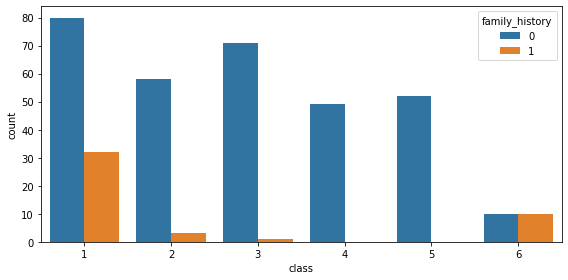

In [5]:
# Class vs Family History
plt.figure(figsize=(8,4))
ax = sns.countplot(x='class', hue='family_history', data=w_filled)
plt.tight_layout()

<AxesSubplot:xlabel='class', ylabel='age'>

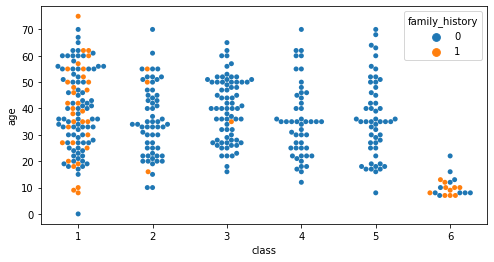

In [6]:
# Class, age and family history
plt.figure(figsize=(8,4))
sns.swarmplot(x='class', y='age', hue='family_history',data=w_filled)

<AxesSubplot:xlabel='class', ylabel='age'>

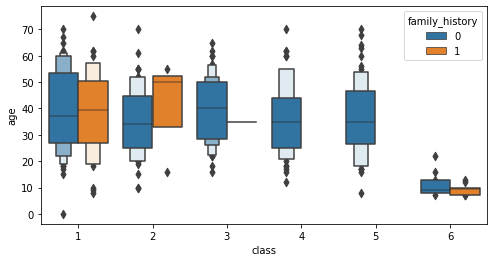

In [7]:
# Boxenplot of class, age, family_history
plt.figure(figsize=(8,4))
sns.boxenplot(x='class', y='age', hue='family_history',data=w_filled)

<AxesSubplot:xlabel='class', ylabel='age'>

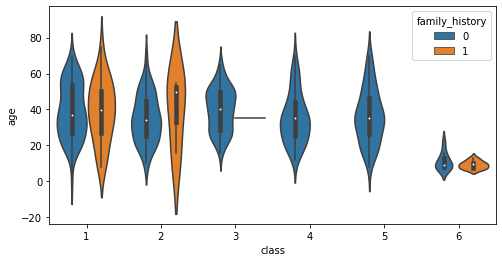

In [8]:
# Violinplot of class, age, family_history
plt.figure(figsize=(8,4))
sns.violinplot(x='class', y='age', hue='family_history',data=w_filled)

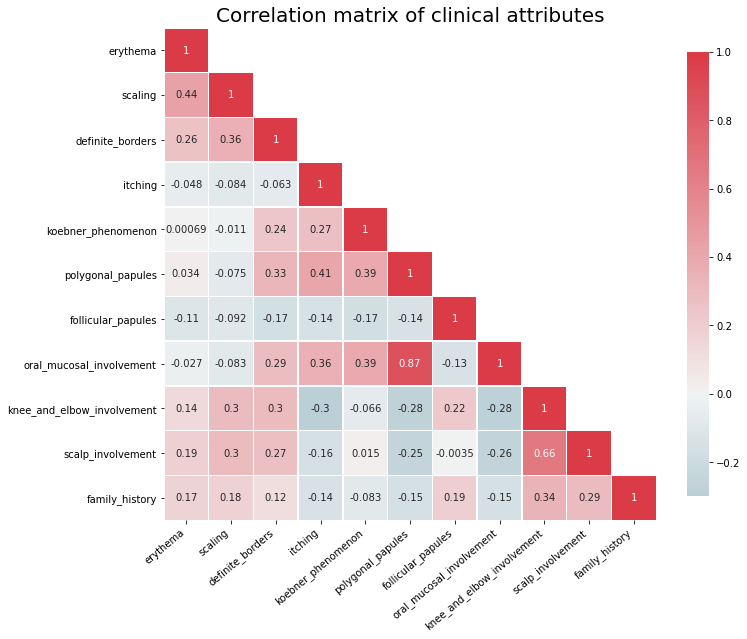

In [9]:
#Correlation matrix of clinical attribute
corr = w_filled.iloc[:, :11].corr()
# Generate a mask for the upper half triangle
mask = np.zeros_like(corr,dtype=bool)
mask[np.triu_indices_from(mask, k=1)] = True

# Set up matplotlib figure
fig, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap,annot=True,  center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .9})
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_title('Correlation matrix of clinical attributes', fontsize=20)
plt.tight_layout()

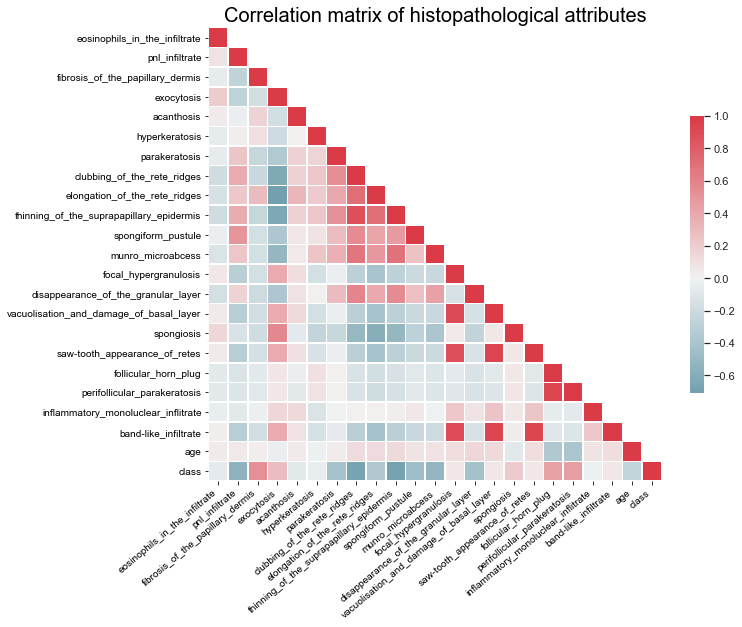

In [10]:
#Correlation matrix of histopathological attributes
corr = w_filled.iloc[:, 12:].corr()
# Generate a mask for the upper half triangle
mask = np.zeros_like(corr,dtype=bool)
mask[np.triu_indices_from(mask, k=1)] = True

# Set up matplotlib figure
fig, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.set(font_scale=1)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .6})
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_title('Correlation matrix of histopathological attributes', fontsize=20)
plt.tight_layout()

Data normalization

In [11]:
#Normalization using StandardScaler

scaler = StandardScaler()
w_norm= w_filled
w_norm.iloc[:,:-1] = scaler.fit_transform(w_filled.iloc[:,:-1])
w_norm.head()

,erythema,scaling,definite_borders,itching,koebner_phenomenon,polygonal_papules,follicular_papules,oral_mucosal_involvement,knee_and_elbow_involvement,scalp_involvement,...,disappearance_of_the_granular_layer,vacuolisation_and_damage_of_basal_layer,spongiosis,saw-tooth_appearance_of_retes,follicular_horn_plug,perifollicular_parakeratosis,inflammatory_monoluclear_inflitrate,band-like_infiltrate,age,class
0,-0.102895,0.292503,-1.709375,1.437334,-0.699049,-0.468702,-0.292496,-0.452637,0.392453,-0.574000,...,-0.537770,-0.478502,1.813219,-0.475701,-0.230817,-0.235125,-1.194459,-0.502215,1.237583,2
1,1.403482,1.719916,1.600843,0.557628,0.403761,-0.468702,-0.292496,-0.452637,0.392453,0.531705,...,-0.537770,-0.478502,-0.844878,-0.475701,-0.230817,-0.235125,-1.194459,-0.502215,-1.867565,1
2,-0.102895,-1.134911,0.497437,1.437334,0.403761,2.669312,-0.292496,3.148777,-0.626255,-0.574000,...,-0.537770,1.618885,1.813219,1.621970,-0.230817,-0.235125,0.184632,2.214200,-0.678360,3
3,-0.102895,0.292503,0.497437,-1.201784,-0.699049,-0.468702,-0.292496,-0.452637,2.429870,1.637410,...,2.935592,-0.478502,-0.844878,-0.475701,-0.230817,-0.235125,1.563724,-0.502215,0.246578,1
4,-0.102895,1.719916,0.497437,0.557628,1.506571,1.623308,-0.292496,1.948306,-0.626255,-0.574000,...,1.777805,2.667578,0.927187,2.670805,-0.230817,-0.235125,0.184632,2.214200,0.576913,3


Train test Split

In [12]:
#User train_set_split to seperate training set and test set

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(w_norm.iloc[:,:-1], w_norm.iloc[:,-1],test_size = 0.3, random_state = 123)

Random Forest

In [13]:
#Search for the best parameters with GridSearchCV
rf_para = [{'n_estimators':[50, 100,150], 'max_depth':[5,10,15], 'max_features':[0.05, 0.1, 0.3], \
           'min_samples_leaf':[1,3], 'bootstrap':[True, False]}]
rfc = GridSearchCV(RandomForestClassifier(), param_grid=rf_para, cv = 10, n_jobs=-1)
rfc.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid=[{'bootstrap': [True, False], 'max_depth': [5, 10, 15],
                          'max_features': [0.05, 0.1, 0.3],
                          'min_samples_leaf': [1, 3],
                          'n_estimators': [50, 100, 150]}])

In [14]:
print('Best accuracy obtained: {}'.format(rfc.best_score_))
print('Parameters:')
for key, value in rfc.best_params_.items():
    print('\t{}:{}'.format(key, value))

Best accuracy obtained: 0.9961538461538462
Parameters:
	bootstrap:True
	max_depth:5
	max_features:0.1
	min_samples_leaf:1
	n_estimators:100


In [15]:
RFC = RandomForestClassifier(max_depth=5, max_features=0.1, min_samples_leaf=1, n_estimators = 100, bootstrap=True, n_jobs=1)
RFC.fit(X_train, y_train)
predict = RFC.predict(X_test)
accuracy = accuracy_score(y_test, predict)
print('accuracy:%0.2f%%'%(accuracy*100))

accuracy:95.45%


In [16]:
def plot_confusion_matrix(cm, classes):    
    #This function prints and plots the confusion matrix.
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    mask = np.zeros_like(cm)
    mask[np.triu_indices_from(mask, k=1)] = True

    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,10))

    sns.set(font_scale=2)
    sns.heatmap(cm,  annot=True,xticklabels = classes, yticklabels = classes,
                mask=mask, linewidths=.5, square =True,  ax=ax1)
    ax1.set(xlabel='Predicted', ylabel='Actual')
    ax1.set_title('Confusion matrix', fontsize=30)
    sns.heatmap(cm_norm, annot=True,xticklabels = classes, yticklabels =False,
                mask=mask, linewidths=.5,square =True, ax=ax2)
    ax2.set(xlabel='Predicted')
    ax2.set_title('Normalized confusion matrix', fontsize=30)
    plt.tight_layout()

In [17]:
Attributes = ["Erythema" , "Scaling", "Sefinite borders", "Itching", "Koebner phenomenon", "Polygonal papules",
              "Follicular papules", "Oral mucosal_involvement", "Knee elbow involvement", "Scalp involvement",
              "Family history", "Melanin incontinence", "Eosinophils in the infiltrate", "PNL infiltrate",
              "Fibrosis of the papillary dermis", "Exocytosis", "acanthosis", "Hyperkeratosis", "Parakeratosis",
              "Clubbing of the rete ridges", "Elongation of the rete ridges",
              "Thinning of the suprapapillary epidermis", "Spongiform pustule", "Munro microabcess",
              "Focal hypergranulosis", "Disappearance of the granular layer", 
              "Vacuolisation and damage of basal layer", "Spongiosis", "Saw-tooth appearance of retes",
              "Follicular horn plug", "Perifollicular parakeratosis", "Inflammatory monoluclear inflitrate",
              "Band-like infiltrate", "Age", "Class"]
classes = ["Psoriasis", "Seboreic dermatitis", "Lichen planus", "Pityriasis rosea", "Cronic dermatitis",
           "Pityriasis rubra pilaris"]

[[34  0  0  0  0  0]
 [ 1 18  0  0  0  0]
 [ 0  0 21  0  0  0]
 [ 0  4  0 12  0  0]
 [ 0  0  0  0 14  0]
 [ 0  0  0  0  0  6]]


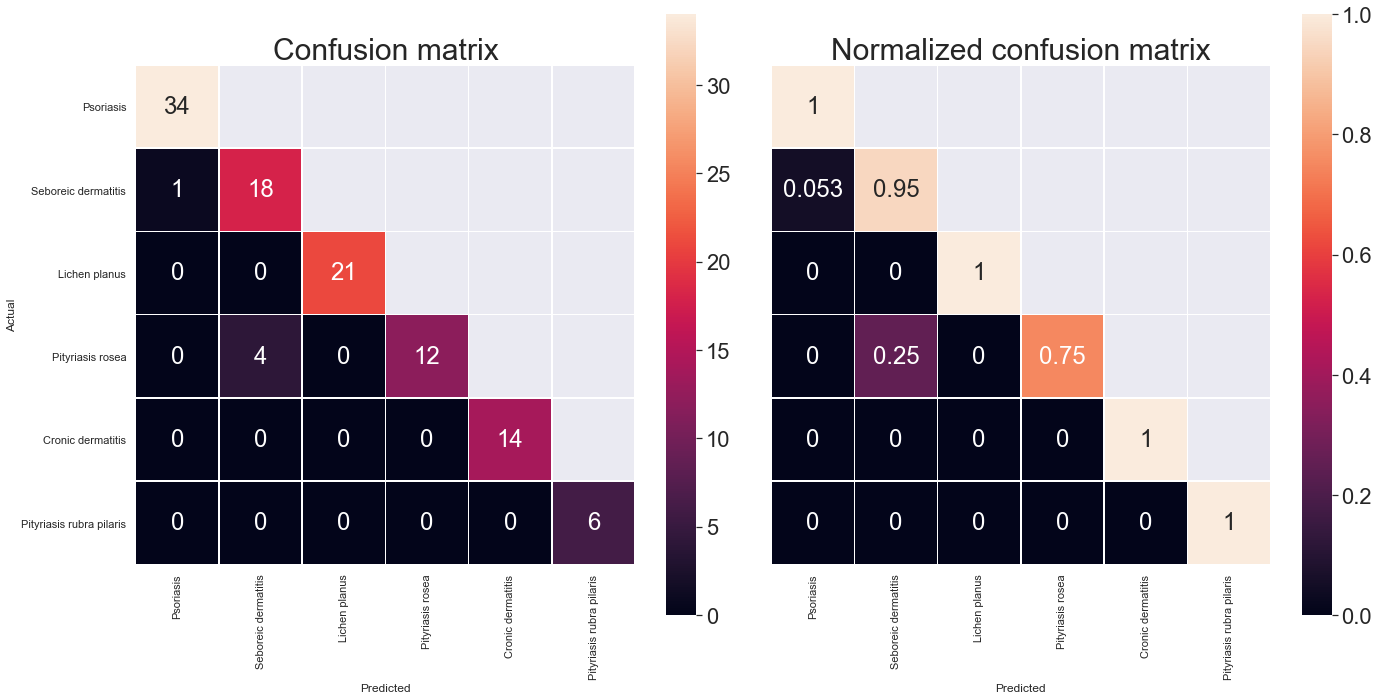

In [18]:
cnf_matrix = confusion_matrix(y_test, predict)
print(cnf_matrix)
plot_confusion_matrix(cnf_matrix, classes=classes)

In [19]:
print(classification_report(y_test, predict, target_names = classes))

                          precision    recall  f1-score   support

               Psoriasis       0.97      1.00      0.99        34
     Seboreic dermatitis       0.82      0.95      0.88        19
           Lichen planus       1.00      1.00      1.00        21
        Pityriasis rosea       1.00      0.75      0.86        16
       Cronic dermatitis       1.00      1.00      1.00        14
Pityriasis rubra pilaris       1.00      1.00      1.00         6

                accuracy                           0.95       110
               macro avg       0.96      0.95      0.95       110
            weighted avg       0.96      0.95      0.95       110



ExtraTreesClassifier

In [20]:
etc_para = [{'n_estimators':[20,30,100, 200], 'max_depth':[5,10,15], 'max_features':[0.1,0.2,0.3, 0.4, 0.5]}] 

In [21]:
ETC = GridSearchCV(ExtraTreesClassifier(),param_grid=etc_para, cv=10, n_jobs=-1)
ETC.fit(X_train,y_train)
ETC.best_params_

{'max_depth': 5, 'max_features': 0.2, 'n_estimators': 100}

In [22]:
print('Best accuracy obtained: {}'.format(ETC.best_score_))
print('Parameters:')
for key, value in ETC.best_params_.items():
    print('\t{}:{}'.format(key, value))

Best accuracy obtained: 0.9923076923076923
Parameters:
	max_depth:5
	max_features:0.2
	n_estimators:100


In [23]:
#Classification report
pred = ETC.predict(X_test)
print(classification_report(y_test, pred, target_names = classes))

                          precision    recall  f1-score   support

               Psoriasis       0.97      1.00      0.99        34
     Seboreic dermatitis       0.82      0.95      0.88        19
           Lichen planus       1.00      1.00      1.00        21
        Pityriasis rosea       1.00      0.75      0.86        16
       Cronic dermatitis       1.00      1.00      1.00        14
Pityriasis rubra pilaris       1.00      1.00      1.00         6

                accuracy                           0.95       110
               macro avg       0.96      0.95      0.95       110
            weighted avg       0.96      0.95      0.95       110



[[34  0  0  0  0  0]
 [ 1 18  0  0  0  0]
 [ 0  0 21  0  0  0]
 [ 0  4  0 12  0  0]
 [ 0  0  0  0 14  0]
 [ 0  0  0  0  0  6]]


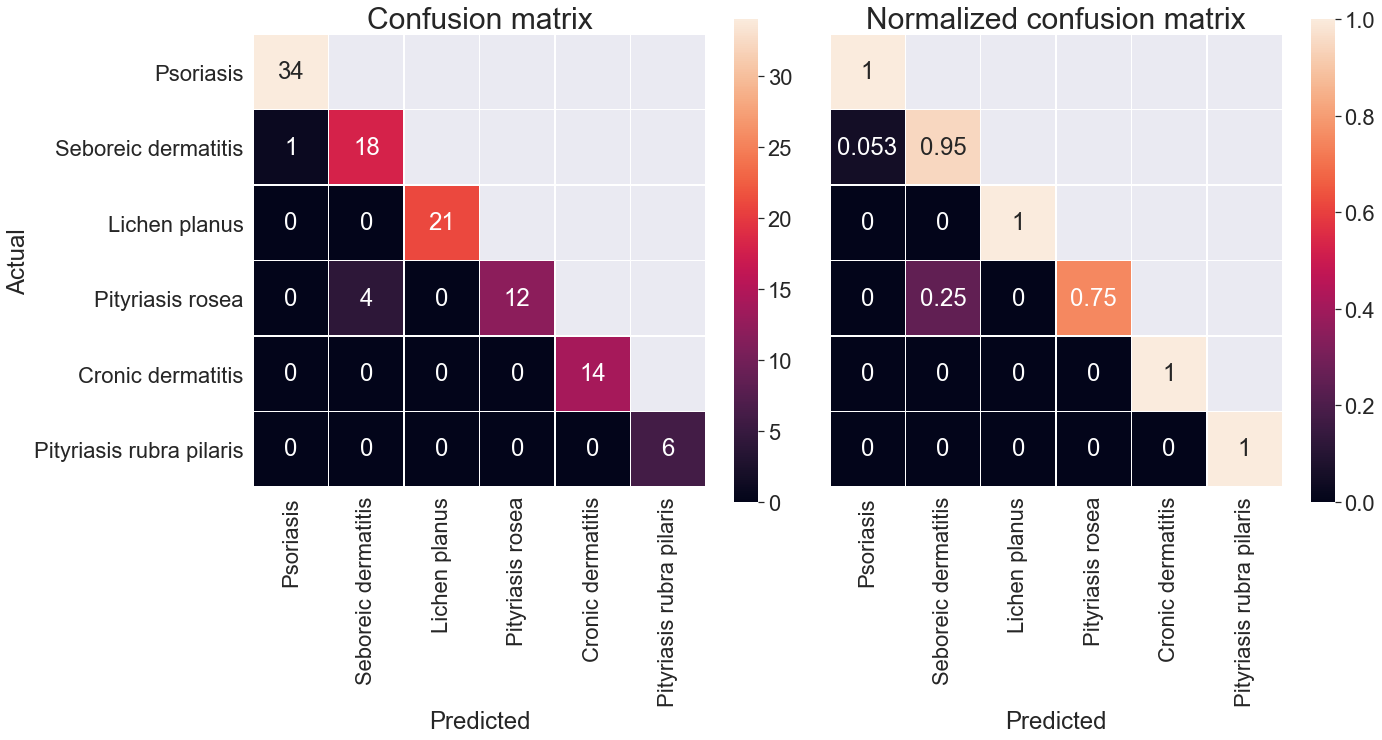

In [24]:
cnf_matrix = confusion_matrix(y_test, pred)
print(cnf_matrix)
plot_confusion_matrix(cnf_matrix, classes=classes)

XgBoost

In [25]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=None)

params_dist_grid = [{
    'max_depth': [1,3, 5, 10],
    'gamma': [0, 0.5, 1],
    'n_estimators': randint(1, 1001), # uniform discrete random distribution
    'learning_rate': uniform(), # gaussian distribution
    'subsample': uniform(), # gaussian distribution
    'colsample_bytree': uniform(), # gaussian distribution
    'reg_lambda':uniform(),
    'reg_alpha':uniform()
    }]

xgbc_fixed = [{'booster':['gbtree'], 'silent':1}]

In [26]:
bst_gridd = RandomizedSearchCV(estimator=XGBClassifier(xgbc_fixed), param_distributions=params_dist_grid,\
                               scoring='accuracy', cv=cv, n_jobs=-1)

In [27]:
#le = LabelEncoder()
#y_train = le.fit_transform(y_train)
bst_gridd.fit(X_train,y_train)
bst_gridd.cv_results_

print ('Best accuracy obtained: {}'.format(bst_gridd.best_score_))
print ('Parameters:')
for key, value in bst_gridd.best_params_.items():
    print('\t{}:{}'.format(key,value))

Best accuracy obtained: 0.9884615384615385
Parameters:
	colsample_bytree:0.4384147159865881
	gamma:0
	learning_rate:0.09745905975575209
	max_depth:5
	n_estimators:938
	reg_alpha:0.788475327872123
	reg_lambda:0.8575855868592206
	subsample:0.09799469119689364


In [28]:
eval_set = [(X_test, y_test)]

XGBC = XGBClassifier(n_estimators=938,learning_rate=0.09745905975575209,max_depth=5,gamma=0,nthread=-1,\
                    reg_alpha = 0.788475327872123, reg_lambda= 0.8575855868592206, max_delta_step = 1, \
                     subsample = 0.09799469119689364, colsample_bytree =0.4384147159865881)

In [29]:
XGBC.fit(X_train, y_train, early_stopping_rounds=100, eval_set=eval_set, eval_metric='merror', verbose=False)
y_pred = XGBC.predict(X_test)
accuracy = accuracy_score(y_test, y_pred);
print ('accuracy:%0.2f%%'%(accuracy*100))

accuracy:96.36%


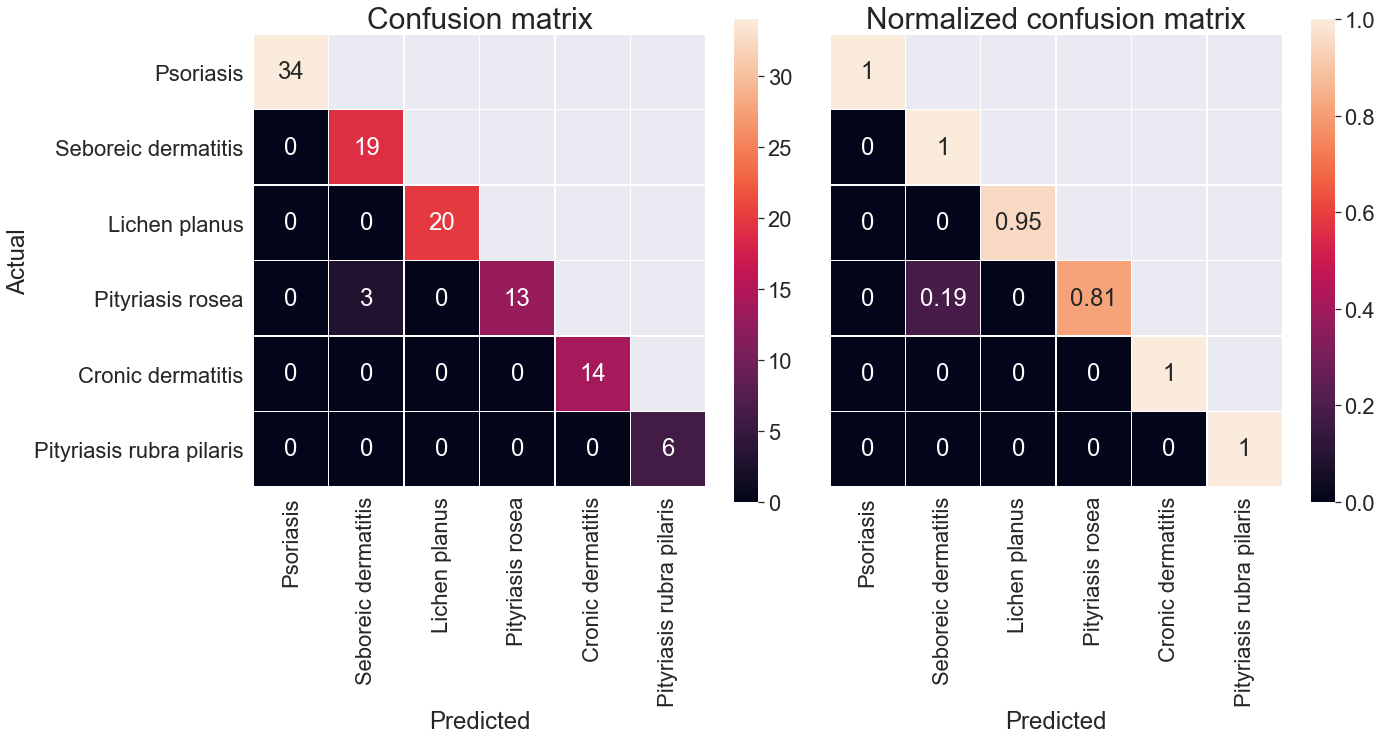

In [31]:
cnf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cnf_matrix, classes=classes)

Support Vector Machines (SVM)

In [37]:
svm_para = [{'kernel':['rbf'],'C': [1,10,100,100]}]
classifier = GridSearchCV(svm.SVC(),svm_para,cv=3,verbose=2)
classifier.fit(X_train,y_train)
classifier.cv_results_
classifier.best_params_

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END ....................................C=1, kernel=rbf; total time=   0.0s
[CV] END ....................................C=1, kernel=rbf; total time=   0.0s
[CV] END ....................................C=1, kernel=rbf; total time=   0.0s
[CV] END ...................................C=10, kernel=rbf; total time=   0.0s
[CV] END ...................................C=10, kernel=rbf; total time=   0.0s
[CV] END ...................................C=10, kernel=rbf; total time=   0.0s
[CV] END ..................................C=100, kernel=rbf; total time=   0.0s
[CV] END ..................................C=100, kernel=rbf; total time=   0.0s
[CV] END ..................................C=100, kernel=rbf; total time=   0.0s
[CV] END ..................................C=100, kernel=rbf; total time=   0.0s
[CV] END ..................................C=100, kernel=rbf; total time=   0.0s
[CV] END ..................................C=100,

{'C': 10, 'kernel': 'rbf'}

In [38]:
# Parameters optimized using the code in above cell
C_opt = 10 # reasonable option
clf = svm.SVC(C=C_opt,kernel='rbf')
clf.fit(X_train,y_train)

SVC(C=10)

In [39]:
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred);
print ('accuracy:%0.2f%%'%(accuracy*100))

accuracy:96.36%


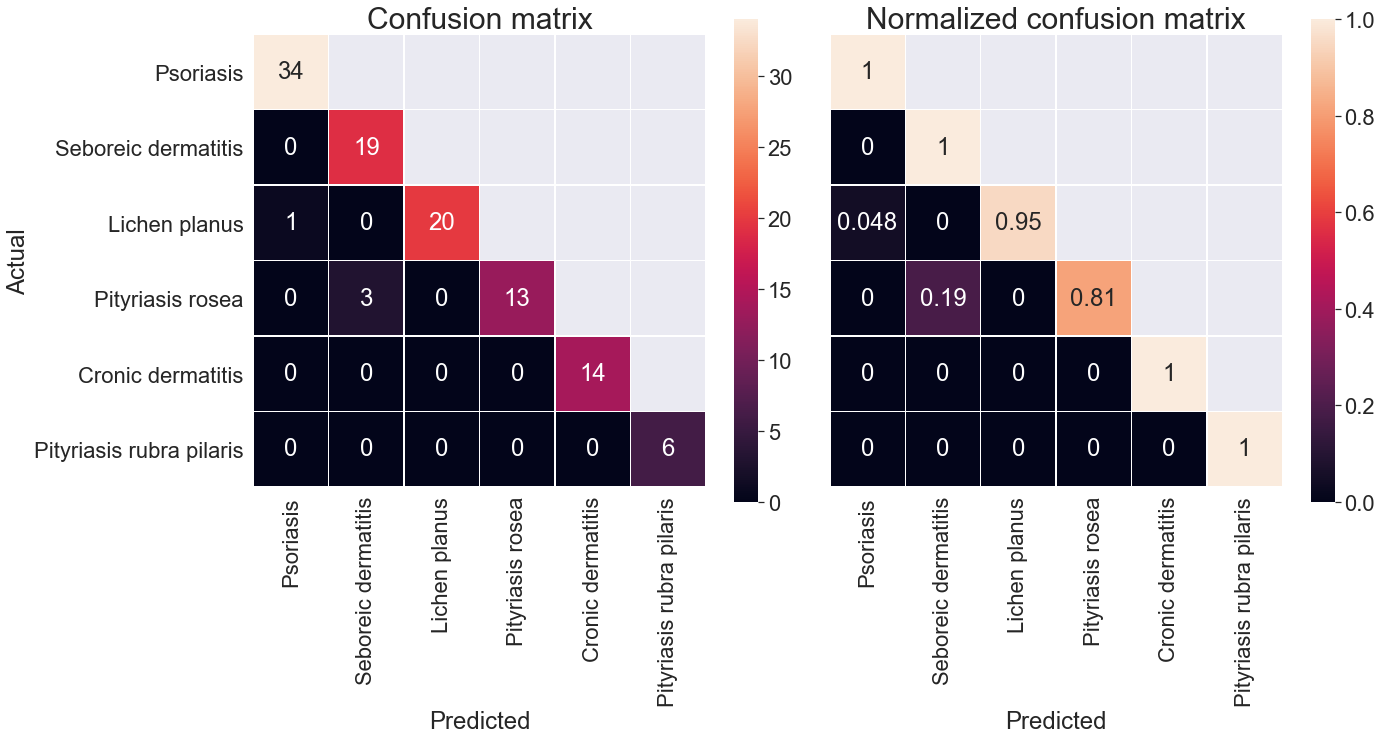

In [40]:
cnf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cnf_matrix, classes=classes)